# Brain Tumor Classification with PyTorch⚡Lightning & ResNet 3D

The goal of this challenge is to Predict the status of a genetic biomarker important for brain cancer treatment.

All the code is refered from public repository: https://github.com/Borda/kaggle_vol-3D-classify
Any nice contribution is welcome!

In [1]:
! pip uninstall -y kaggle_volclassif
! pip install -q https://github.com/Borda/kaggle_vol-3D-classify/archive/refs/heads/main.zip
# ! pip install -q https://github.com/Borda/kaggle_vol-3D-classify/archive/refs/tags/v0.3.2.zip
! pip install -q "pytorch-lightning>=1.3.8"
! pip uninstall -q -y wandb
# !pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
! pip list | grep torch

Found existing installation: kaggle-brain3D 0.3.2
Uninstalling kaggle-brain3D-0.3.2:
  Successfully uninstalled kaggle-brain3D-0.3.2
pytorch-lightning             1.3.8                /home/jirka/.local/lib/python3.8/site-packages
torch                         1.9.1+cu111          
torchaudio                    0.9.1                
torchmetrics                  0.5.1                
torchsummary                  1.5.1                
torchvision                   0.10.1+cu111         


In [2]:
! ls -l /home/jirka/Datasets/rsna-miccai-brain-tumor
! nvidia-smi -L
! mkdir /home/jirka/TEMP/brain-tumor

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import kaggle_volclassif
print(kaggle_volclassif.__version__)

total 36
-rw-rw-r--   1 jirka jirka   891 Jun 29 03:18 sample_submission.csv
drwxrwxr-x  89 jirka jirka  4096 Oct 15 10:06 test
drwxrwxr-x 587 jirka jirka 20480 Oct 15 10:17 train
-rw-rw-r--   1 jirka jirka  4701 Jun 29 06:03 train_labels.csv
GPU 0: A100-SXM4-40GB (UUID: GPU-7b693b1c-bfe4-4e91-b886-7b980b9bc60d)
GPU 1: A100-SXM4-40GB (UUID: GPU-efc5218d-a533-651a-08bf-97916434d595)
GPU 2: A100-SXM4-40GB (UUID: GPU-f0687420-e4a4-c246-3044-e5224f456289)
GPU 3: A100-SXM4-40GB (UUID: GPU-bc52cd8b-d3d2-6173-ed00-67af6a2c994c)
GPU 4: A100-SXM4-40GB (UUID: GPU-f6ceefea-f265-f7ce-ace4-2b354f844889)
GPU 5: A100-SXM4-40GB (UUID: GPU-a5b5571a-b037-3000-0735-a899935eaff7)
GPU 6: A100-SXM4-40GB (UUID: GPU-64bd2a06-f72b-306f-4379-129491fc30d0)
GPU 7: A100-SXM4-40GB (UUID: GPU-988555ae-cab7-8854-9855-337704520e6f)
mkdir: cannot create directory ‘/home/jirka/TEMP/brain-tumor’: File exists
0.3.3


## Data exploration

These 3 cohorts are structured as follows: Each independent case has a dedicated folder identified by a five-digit number.
Within each of these “case” folders, there are four sub-folders, each of them corresponding to each of the structural multi-parametric MRI (mpMRI) scans, in DICOM format.
The exact mpMRI scans included are:

- **FLAIR**: Fluid Attenuated Inversion Recovery
- **T1w**: T1-weighted pre-contrast
- **T1Gd**: T1-weighted post-contrast
- **T2w**: T2-weighted

#### according to https://www.aapm.org/meetings/amos2/pdf/34-8205-79886-720.pdf

- T1: weighting better deliniates anatomy
- T2: weighting naturally shows pathology

#### according to https://radiopaedia.org/articles/fluid-attenuated-inversion-recovery

Fluid attenuated inversion recovery (FLAIR) is a special inversion recovery sequence with a long inversion time. This removes signal from the cerebrospinal fluid in the resulting images 1. Brain tissue on FLAIR images appears similar to T2 weighted images with grey matter brighter than white matter but CSF is dark instead of bright.

To null the signal from fluid, the inversion time (TI) of the FLAIR pulse sequence is adjusted such that at equilibrium there is no net transverse magnetization of fluid.

The FLAIR sequence is part of almost all protocols for imaging the brain, particularly useful in the detection of subtle changes at the periphery of the hemispheres and in the periventricular region close to CSF.

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH_DATASET = "/home/jirka/Datasets/rsna-miccai-brain-tumor"
PATH_MODELS = "/home/jirka/Workspace/pretrained_medical"
PATH_TEMP = "/home/jirka/TEMP/brain-tumor"
SCAN_TYPES = ("FLAIR", "T1w", "T1CE", "T2w")

df_train = pd.read_csv(os.path.join(PATH_DATASET, "train_labels.csv"))
df_train["BraTS21ID"] = df_train["BraTS21ID"].apply(lambda i: "%05d" % i)
display(df_train.head())

,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


See the dataset label distribution

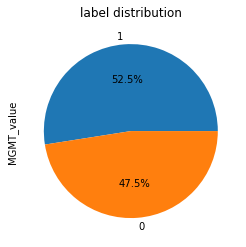

In [ ]:
_= df_train["MGMT_value"].value_counts().plot(kind="pie", title="label distribution", autopct="%.1f%%")

For almost all scans we have all four types

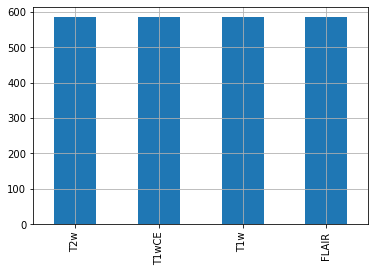

In [ ]:
scans = [os.path.basename(p) for p in glob.glob(os.path.join(PATH_DATASET, "train", "*", "*"))]
_= pd.Series(scans).value_counts().plot(kind="bar", grid=True)

### Interactive view

showing particular scan in XYZ dimension/slices

In [6]:
from ipywidgets import interact, IntSlider

from kaggle_volclassif.utils import load_volume, interpolate_volume, show_volume
from kaggle_volclassif.transforms import crop_volume


def interactive_show(volume_path: str, crop_thr: float):
    print(f"loading: {volume_path}")
    volume = load_volume(volume_path, percentile=0)
    print(f"sample shape: {volume.shape} >> {volume.dtype}")
    volume = interpolate_volume(volume)
    print(f"interp shape: {volume.shape} >> {volume.dtype}")
    volume = crop_volume(volume, crop_thr)
    print(f"crop shape: {volume.shape} >> {volume.dtype}")
    vol_shape = volume.shape
    interact(
        lambda x, y, z: plt.show(show_volume(volume, x, y, z)),
        x=IntSlider(min=0, max=vol_shape[0], step=5, value=int(vol_shape[0] / 2)),
        y=IntSlider(min=0, max=vol_shape[1], step=5, value=int(vol_shape[1] / 2)),
        z=IntSlider(min=0, max=vol_shape[2], step=5, value=int(vol_shape[2] / 2)),
    )


PATH_SAMPLE_VOLUME = os.path.join(PATH_DATASET, "train", "00005", "FLAIR")

interactive_show(PATH_SAMPLE_VOLUME, crop_thr=1e-6)

loading: /home/jirka/Datasets/rsna-miccai-brain-tumor/train/00005/FLAIR
sample shape: torch.Size([512, 512, 400]) >> torch.float32
interp shape: torch.Size([512, 512, 512]) >> torch.float32
crop shape: torch.Size([264, 266, 509]) >> torch.float32


interactive(children=(IntSlider(value=132, description='x', max=264, step=5), IntSlider(value=133, description…

## Prepare dataset

### Pytorch Dataset

The basic building block is traforming raw data to Torch Dataset.
We have here loading particular DICOM images into a volume and saving as temp/cacher, so we do not need to take the very time demanding loading do next time - this boost the IO from about 2h to 8min

At the end we show a few sample images from prepared dataset.

shape: torch.Size([128, 128, 128]), x=64, y=64, z=64  >> torch.float32
shape: torch.Size([128, 128, 128]), x=64, y=64, z=64  >> torch.float32



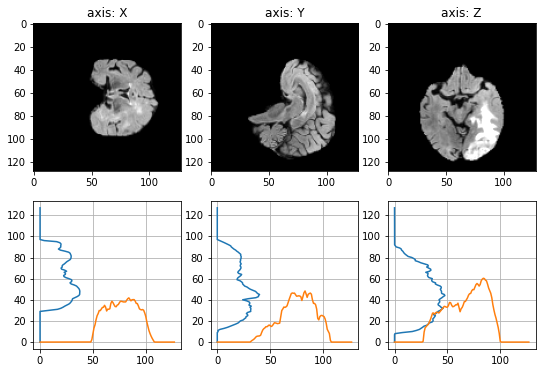

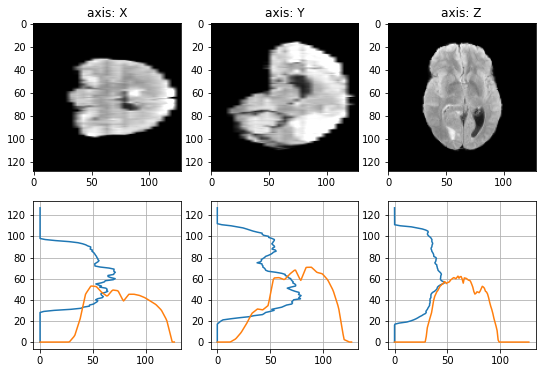

In [ ]:
import os
import pandas as pd
import torch
from tqdm.auto import tqdm

from kaggle_volclassif.data import BrainScansDataset
from kaggle_volclassif.transforms import resize_volume

# ==============================

ds = BrainScansDataset(
    image_dir=os.path.join(PATH_DATASET, "train"),
    df_table=os.path.join(PATH_DATASET, "train_labels.csv"),
    crop_thr=None,
    cache_dir=PATH_TEMP,
)
for i in tqdm(range(2)):
    img = ds[i * 10]["data"]
    img = resize_volume(img[0])
    show_volume(img, fig_size=(9, 6))

### Lightning DataModule

It is constric to wrap all data-related peaces and define Pytoch dataloder for Training / Validation / Testing phase.

At the end we show a few sample images from the fost training batch.

Dataset >> mean: 0.13732214272022247 STD: 0.24326834082603455
Training batches: 117 and Validation 30


/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  rank_zero_deprecation(


shape: torch.Size([224, 224, 224]), x=112, y=112, z=112  >> torch.float32
shape: torch.Size([224, 224, 224]), x=112, y=112, z=112  >> torch.float32


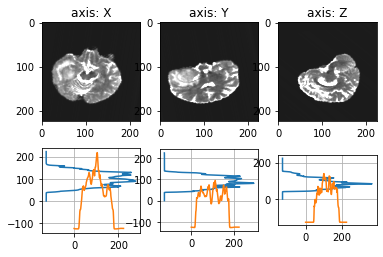

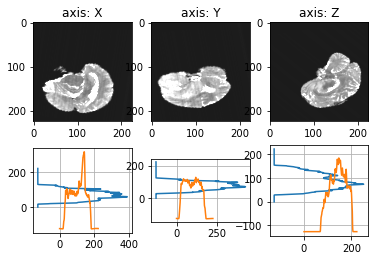

In [ ]:
from functools import partial
import rising.transforms as rtr
from rising.loading import DataLoader, default_transform_call
from rising.random import DiscreteParameter, UniformParameter

from kaggle_volclassif.data import BrainScansDM, TRAIN_TRANSFORMS, VAL_TRANSFORMS
from kaggle_volclassif.transforms import RandomAffine, rising_zero_mean

# ==============================

dm = BrainScansDM(
    data_dir=PATH_DATASET,
    scan_types=["T2w"],
    # input_size=224,  # deprecated in v0.3
    vol_size=224,
    crop_thr=None,
    # crop_thr=1e-6,  # experimental crop threshold
    batch_size=12,  # for full model training
    # batch_size=6,  # for finetune head
    # cache_dir=None,
    cache_dir=PATH_TEMP,
    in_memory=True,
    num_workers=64,
    split=0.9,
    train_transforms=rtr.Compose(TRAIN_TRANSFORMS, transform_call=default_transform_call),
    valid_transforms=rtr.Compose(VAL_TRANSFORMS, transform_call=default_transform_call),
)
dm.prepare_data(num_proc=0)
dm.setup()
# dm.prepare_data(num_proc=0, dataset=dm.test_dataset)
print(f"Training batches: {len(dm.train_dataloader())}")
print(f"Validation batches: {len(dm.val_dataloader())}")
print(f"Test batches: {len(dm.test_dataloader())}")

# Quick view
for batch in dm.train_dataloader():
    for i in range(2):
        show_volume(batch["data"][i][0], fig_size=(6, 4), v_min_max=(-1., 3.))
    break

## Prepare 3D model

LightningModule is the core of PL, it wrappes all model related peaces, mainly:

- the model/architecture/weights
- evaluation metrics
- configs for optimizer and LR scheduler

In [9]:
from torchsummary import summary
from kaggle_volclassif.models import LitBrainMRI, create_pretrained_medical_resnet
from monai.networks.nets import resnet10, resnet18, resnet34, resnet50, SEResNet50
from torch.optim import SGD, ASGD, Adamax

# ==============================

PATH_PRETRAINED_WEIGHTS = os.path.join(PATH_MODELS, "resnet_34_23dataset.pth")
net, pretraineds_layers = create_pretrained_medical_resnet(PATH_PRETRAINED_WEIGHTS, model_constructor=resnet34)

# net = SEResNet50(spatial_dims=3, in_channels=1, pretrained=True, num_classes=2)

model = LitBrainMRI(net=net, pretrained_params=None, lr=5e-4, optimizer=Adamax)
# summary(model, input_size=(1, 128, 128, 128))

/home/jirka/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## Train a model

Lightning forces the following structure to your code which makes it reusable and shareable:

- Research code (the LightningModule).
- Engineering code (you delete, and is handled by the Trainer).
- Non-essential research code (logging, etc... this goes in Callbacks).
- Data (use PyTorch DataLoaders or organize them into a LightningDataModule).

Once you do this, you can train on multiple-GPUs, TPUs, CPUs and even in 16-bit precision without changing your code!

In [ ]:
import pytorch_lightning as pl
from kaggle_volclassif.models import FineTuneCB

torch.backends.cudnn.enabled = False

csv_logger = pl.loggers.CSVLogger(save_dir='logs/', name=model.name)
tb_logger = pl.loggers.TensorBoardLogger(save_dir='logs-tb/', name=model.name)
swa = pl.callbacks.StochasticWeightAveraging(swa_epoch_start=0.6)
fine = FineTuneCB(unfreeze_epoch=10)
ckpt = pl.callbacks.ModelCheckpoint(
    monitor='valid/auroc',
    save_top_k=1,
    save_last=True,
    filename='checkpoint/{epoch:02d}-{valid/auroc:.4f}',
    mode='max',
)

# ==============================

trainer = pl.Trainer(
    # overfit_batches=5,
    # fast_dev_run=True,
    gpus=[1],
    callbacks=[ckpt, fine],  #, swa
    logger=[csv_logger, tb_logger],
    max_epochs=35,
    precision=16,
    benchmark=True,
    accumulate_grad_batches=12,
    # val_check_interval=0.5,
    progress_bar_refresh_rate=1,
    log_every_n_steps=5,
    weights_summary='top',
    auto_lr_find=True,
#     auto_scale_batch_size='binsearch',
)

# ==============================

trainer.tune(
    model, 
    datamodule=dm, 
    lr_find_kwargs=dict(min_lr=2e-5, max_lr=1e-2, num_training=25),
    # scale_batch_size_kwargs=dict(max_trials=5),
)
print(f"Batch size: {dm.batch_size}")
print(f"Learning Rate: {model.learning_rate}")

# ==============================

# dm.batch_size = 12
trainer.fit(model=model, datamodule=dm)

### Training progress

logs/ResNet/version_21


,train/loss,train/acc,train/f1,epoch,step,train/auroc,valid/loss,valid/acc,valid/f1,valid/auroc
0,0.691494,0.5,0.0,0,4,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0,4,0.462845,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0,4,NaN,0.693128,0.440678,0.0,0.592075
3,NaN,NaN,NaN,1,8,0.531529,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,1,8,NaN,0.674553,0.440678,0.0,0.699883


<AxesSubplot:xlabel='epoch'>

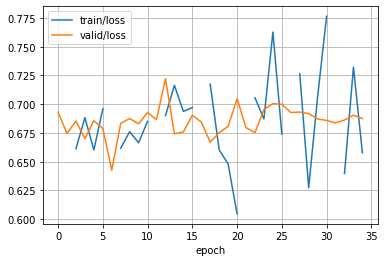

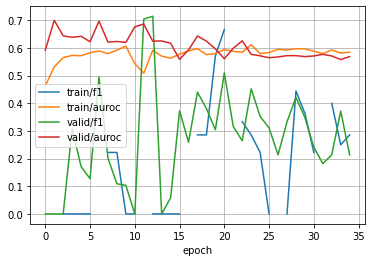

In [11]:
print(csv_logger.log_dir)
metrics = pd.read_csv(f'{csv_logger.log_dir}/metrics.csv')
display(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[['train/loss', 'valid/loss']].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[['train/f1', 'train/auroc', 'valid/f1', 'valid/auroc']].plot(grid=True, legend=True, xlabel=agg_col)

## Predictions

In [12]:
model.eval()
model.cpu()
submission = []

for batch in dm.test_dataloader():
    print(batch.keys())
    print(batch.get("label"))
    imgs = batch.get("data")
    print(imgs.shape)
    with torch.no_grad():
        preds = model(imgs)
    print(preds)
    probs = torch.nn.functional.softmax(preds)
    print(probs)
    break

dict_keys(['data', 'label'])
['00174/T2w', '00114/T2w', '00229/T2w', '00182/T2w', '00287/T2w', '00333/T2w', '00153/T2w', '00769/T2w', '00355/T2w', '00145/T2w', '00129/T2w', '00585/T2w']
torch.Size([12, 1, 224, 224, 224])
tensor([9.9121e-04, 4.4697e-05, 5.2912e-05, 6.7500e-05, 3.0618e-04, 8.5139e-05,
        9.1663e-04, 5.6382e-01, 1.4404e-04, 9.1687e-07, 2.6787e-05, 6.1351e-04])
tensor([0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.0784, 0.1377, 0.0784,
        0.0784, 0.0784, 0.0784])


<ipython-input-12-3aa41e17b31f>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = torch.nn.functional.softmax(preds)


In [14]:
from kaggle_volclassif.models import make_submission

dm.batch_size = 2
df_submission = make_submission_brain(model, dm.test_dataloader(), "cuda" if torch.cuda.is_available() else "cpu")
display(df_submission)
df_submission["MGMT_value"].to_csv("submission.csv")

  0%|          | 0/44 [00:07<?, ?it/s]

,BraTS21ID5,MRI_type,MGMT_value
BraTS21ID,,,
174,00174,T2w,0.000991
114,00114,T2w,0.000045
229,00229,T2w,0.000053
182,00182,T2w,0.000068
287,00287,T2w,0.000306
...,...,...,...
595,00595,T2w,0.388269
647,00647,T2w,0.042377
190,00190,T2w,0.006302


array([[<AxesSubplot:title={'center':'MGMT_value'}>]], dtype=object)

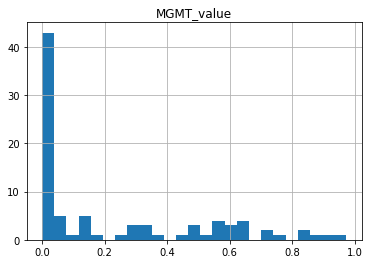

In [15]:
df_submission[["MGMT_value"]].hist(bins=25)